# COMP9418 - Assignment 1 - Bayesian Networks as Classifiers

## UNSW Sydney, September 2021

- Dezhao Chen - z5302273
- Ziqiao Ringgold Lin - z5324329

## Instructions

**Submission deadline:** Sunday, 17th October 2021, at 18:00:00.

**Late Submission Policy:** The penalty is set at 20% per late day. This is ceiling penalty, so if a group is marked 60/100 and they submitted two days late, they still get 60/100.

**Form of Submission:** This is a group assignment. Each group can have up to **two** students. **Only one member of the group should submit the assignment**.

You can reuse any piece of source code developed in the tutorials.

Submit your files using give. On a CSE Linux machine, type the following on the command-line:

``$ give cs9418 ass1 solution.zip``

Alternative, you can submit your solution via [WebCMS](https://webcms3.cse.unsw.edu.au/COMP9418/21T3).

## Technical prerequisites

These are the libraries your are allowed to use. No other libraries will be accepted. Make sure you are using Python 3.

In [1]:
# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import math
from itertools import product, combinations
from graphviz import Digraph
from tabulate import tabulate
import copy

We can also use the python files we developed in tutorials, or any other code from the tutorials.

In [2]:
from DiscreteFactors import Factor
from Graph import Graph
from BayesNet import BayesNet            

## Initial task - Initialise graph

Create a graph ``G`` that represents the following network by filling in the edge lists.
![Bayes Net](BayesNet.png)


In [3]:
G = Graph({
    "BreastDensity" : ["Mass"],
    "Location" : ["BC"],
    "Age" : ["BC"],
    "BC" : ["Metastasis","MC","SkinRetract","NippleDischarge","AD","Mass"],
    "Mass" : ["Size","Shape","Margin"],
    "AD" : ["FibrTissueDev"],
    "Metastasis" : ["LymphNodes"],
    "MC" : [],
    "Size" : [],
    "Shape" : [],
    "FibrTissueDev" : ["SkinRetract","NippleDischarge","Spiculation"],
    "LymphNodes" : [],
    "SkinRetract" : [],
    "NippleDischarge" : [],
    "Spiculation" : ["Margin"],
    "Margin" : [],
})

### Load data

In [4]:
# load data
with open('bc.csv') as file:
    data = pd.read_csv(file)

#remove 2 variables from data (because we are pretending we don't know this information)
if 'Metastasis' in data:
    del data['Metastasis']
if 'LymphNodes' in data:
    del data['LymphNodes']

# remove same 2 nodes from graph
G.remove_node('Metastasis')
G.remove_node('LymphNodes')

## [20 Marks] Task 1 - Efficient d-separation test

Implement the efficient version of the d-separation algorithm in a function ``d_separation(G, X, Z, Y)`` that return a boolean: ``True`` if **X** is d-separated from **Y** given **Z** in the graph $G$ and ``False`` otherwise.

* **X**,**Y** and **Z** are python sets, each containing a set of variable names. 
* Variable names may be strings or integers, and can be assumed to be nodes of the graph $G$. 
* $G$ is a directed graph object as defined in tutorial 1.

In [5]:
def d_separation(G, X, Z, Y):
    '''
    Arguments:
    G:   is an object of type Graph (the class you developed in tutorial 1)
    X,Z and Y:  are python `set` objects.
    '''
    # Step 0: Make a deep copy of the gragh G in case we need to reuse the same graph later
    G_dict = copy.deepcopy(G.adj_list)
    G_copy = Graph(G_dict)

    # Step 1: Keep deleting any leaf nodes from G if it's not in X∪Y∪Z
    set_XYZ = (X.union(Y)).union(Z)
    while True:
        deletable_leafs = []
        for node in G_copy.adj_list.keys():
            # Get all deletable leaves for current G
            if node not in set_XYZ and len(G_copy.adj_list[node]) == 0:
                deletable_leafs.append(node)
        if len(deletable_leafs) == 0:
            # Stop the leaf deletion after no more isolated leaves found
            break
        else:
            # Remove the deletable leaves from G in this round
            for node in deletable_leafs:
                G_copy.remove_node(node)

    # Step 2: Remove any outgoing edges from node(s) Z
    for node in Z:
        G_copy.adj_list[node] = []

    # Step 3: Make current G undirected
    for key in G_copy.adj_list.keys():
        for node in G_copy.adj_list[key]:
            if key not in  G_copy.adj_list[node]:
                G_copy.adj_list[node].append(key)

    # Step 4: Check the connectivity from X to Y in current graph G
    overall_connected = False
    for node in X:
        connectivity_color_map = G_copy.dfs(node)
        for dest in Y:
            if connectivity_color_map[dest] == 'black' or connectivity_color_map[dest] == 'grey':
                # black or grey indicates this node is found in DFS search for at least once
                overall_connected = True
    return not overall_connected

In [6]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case")
        
test(d_separation(G, set(['Age']), set(['BC']), set(['AD'])))
test(not d_separation(G, set(['Spiculation','SkinRetract']), set(['MC', 'Size']), set(['Age'])))

Passed test case
Passed test case


## [10 Marks] Task 2 - Estimate Bayesian Network parameters from data

Implement a function ``learn_outcome_space(data)`` that learns the outcome space (the valid values for each variable) from the pandas dataframe ``data`` and returns a dictionary ``outcomeSpace`` with these values.

Implement a method ``model.learn_parameters(data, alpha=1)`` that learns the parameters of the Bayesian Network `model`. This function should do the same as the ``learn_parameters`` function from tutorials, but it should also implement laplacian smoothing with parameter $\alpha$.

In [7]:
## Develop your code for learn_outcome_space(data) in one or more cells here

In [8]:
def learn_outcome_space(data):
    '''
    Arguments:
        data - A pandas dataframe
    Returns: 
        outcomeSpace - A dictionary. e.g. {'A':('True', 'False'), 'B':('up','down','left'), 'C':(1,2,3,4)}
    '''
    outcomeSpace = {}
    for col in data.columns:
        outcomeSpace[col] = tuple(data[col].unique())
    return outcomeSpace


outcomeSpace = learn_outcome_space(data)

In [9]:
############
## TEST CODE

outcomeSpace = learn_outcome_space(data)

outcomes = outcomeSpace['BreastDensity']
answer = ('high', 'medium', 'low')
test(len(outcomes) == len(answer) and set(outcomes) == set(answer))

Passed test case


In [10]:
## Develop your code for learnParameters in one or more cells here
def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

def estimateFactor(data, var_name, parent_names, outcomeSpace, alpha):
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    f = Factor(list(parent_names) + [var_name], outcomeSpace)

    for i, parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name]) == var_outcome)
            # Laplacian smoothing
            # p= (c+alpha)/(N+alpha*|X|)
            # tut line: (var_index & parent_index).sum()/parent_index.sum()
            # c = (var_index & parent_index).sum()
            # N = parent_index.sum()
            # we have |X| = len(var_outcomes)
            c = (var_index & parent_index).sum()
            N = parent_index.sum()
            X = len(var_outcomes)
            f[tuple(list(parent_combination) + [var_outcome])] = (c + alpha) / (N + alpha * X)

    return f

In [11]:
class BayesNet(BayesNet):
    def learn_parameters(self, data, alpha=1):
        graphT = self.graph.transpose()
        for node, parents in graphT.adj_list.items():
            f = estimateFactor(data, node, parents, self.outcomeSpace,alpha)
            self.factors[node] = f

model = BayesNet(G,outcomeSpace)

In [12]:
############
## TEST CODE

model.learn_parameters(data, alpha=1)

test(model.factors['Age']['35-49'] == 0.248000399920016)

Passed test case


## [20 Marks] Task 3 - Bayesian Network Classification

Design a new function ``assess_bayes_net(model, dataframe, var)`` that uses the test cases in ``dataframe`` to assess the performance of the Bayesian network at classifying the variable `var`. Implement the efficient classification procedure discussed in the lectures (make sure you understand what a Markov Blanket is). Such a function should return the classifier accuracy. 

 * ``var`` is the name of the variable you are predicting, using the values of all the other variables. 
 
If you like, you can add new functions to the BayesNet class, or write helper functions to help solve the above task.

Using another function called `cross_validation_bayes_net`, compute and report the average accuracy over the ten cross-validation runs as well as the standard deviation. A scaffold for this function is provided below.

In [13]:
## Develop your code for assess_bayes_net in one or more cells here

In [14]:
'''
Here, we create our own query function so that:
1. We do not need to join (all of) the variables' prop table every single time when doing query
2. We can pass custimized table for query, and prevent using oversized table for small queries
'''
class BayesNet(BayesNet):
    def query_without_self_joint(self, table, q_vars, **q_evi):
        """
        arguments 
        `table`, the table used for query
        `q_vars`, list of variables in query head
        `q_evi`, dictionary of evidence in the form of variables names and values

        Returns a new NORMALIZED factor will all hidden variables eliminated as evidence set as in q_evi
        """     
        assert isinstance(q_vars,list) or sinstance(q_vars,tuple), "q_vars should be a list"
        
        f = table
        
        # First, we set the evidence 
        f = f.evidence(**q_evi)

        # Second, we eliminate hidden variables NOT in the query
        for var in self.outcomeSpace:
            if var not in q_vars:
                f = f.marginalize(var)
        return f.normalize()

def get_parents(G):
    '''
    Create a parent nodes dict list for input graph and return it
    '''
    graph_parents_list={}
    for node in G:
        graph_parents_list[node]=[]
    for parent_node in G:
        for child_node in G[parent_node]:
            graph_parents_list[child_node].append(parent_node)
    return graph_parents_list

def get_markov_blanket(model: BayesNet, var: str):
    '''
    1. Find all parents
    2. Find all children
    3. Find all spouses
    '''
    markov_blanket = []
    graph = model.graph.adj_list
    # add children
    markov_blanket = markov_blanket + graph[var]
    # add parent
    graph_parents_list = get_parents(graph)
    markov_blanket = markov_blanket + graph_parents_list[var]
    
    # add all spouses
    for node in graph[var]:
        markov_blanket = markov_blanket + graph_parents_list[node]
    markov_blanket = list(dict.fromkeys(markov_blanket))
    
    # Make sure both verions of markov blankets are returned
    markov_blanket_without_var = copy.deepcopy(markov_blanket)
    if var in markov_blanket:
        markov_blanket_without_var.remove(var)
    else:
        markov_blanket.append(var)
    return markov_blanket, markov_blanket_without_var

def get_related_table(model: BayesNet, var_space: list):
    '''
    Get the joint table of a given bayes net model of a given variable space
    '''
    # Check if var space are all having correct var
    all_table = model.factors
    for var in var_space:
        if var not in all_table.keys():
            var_space.remove(var)

    table = []
    if len(var_space) > 0:
        table = all_table[var_space[0]]
    
    if len(var_space) > 1:
        for i in range(1, len(var_space)):
            table = table.join(all_table[var_space[i]])
    return table

def assess_bayes_net(model, dataframe, var='BC'):
    '''
    Test the accuracy given trained model by using the test dataframe
    '''
    # Get the probability table of all the variables in 'var' markov blanket
    markov_blanket, markov_blanket_without_var = get_markov_blanket(model, var)
    related_test_table = dataframe[markov_blanket]
    correct_amount = 0
    total_amount = 0
    joint_table = get_related_table(model, markov_blanket)
    for row_index, row_data in related_test_table.iterrows():
        # Get evidence and actual value of var from the test data
        var_value_actual = row_data.pop(var)
        row_data_dict = dict(row_data)

        # get p(var|evidence) in an array
        query_result = model.query_without_self_joint(joint_table, [var], **row_data_dict)
        var_possible_values = model.outcomeSpace[var]

        # Get predicted value according to the query table result
        possibility_max = 0
        var_value_prediced = None
        for value in var_possible_values:
            possibility = query_result[value]
            if possibility > possibility_max:
                possibility_max = possibility
                var_value_prediced = value

        # Compare predicted value and actual value of the variable with current evidence
        if var_value_prediced == var_value_actual:
            correct_amount += 1
        total_amount += 1
    accuracy = correct_amount/total_amount
    return accuracy

def cross_validation_bayes_net(dataframe, var='BC', k=10):
    accuracy_list = []
    outcomeSpace = learn_outcome_space(data)
    model = BayesNet(G, outcomeSpace)

    for i in range(k):
        # split dataset into train and test
        length = int(len(dataframe) / k)
        data_train = data.drop([e for e in range(i * length, (i + 1) * length)])
        data_test = data.loc[i * length:(i + 1) * length - 1]
        # train a model
        model.learn_parameters(data_train)
        
        # test the model with assess_bayes_net
        acc = assess_bayes_net(model, data_test, var)
        accuracy_list.append(acc)
    return np.mean(accuracy_list), np.std(accuracy_list)


In [15]:
############
## TEST CODE

acc, stddev = cross_validation_bayes_net(data, 'BC', 10)
test(abs(acc - 0.85) < 0.05)

Passed test case


## [10 Marks] Task 4 - Naïve Bayes Classification

Design a new function ``assess_naive_bayes(model, data, var)`` to classify and assess the test cases in ``data``. To classify each example, use the log probability trick discussed in the lectures. Do $k$-fold cross-validation with the `cross_validation_naive_bayes(data, var, k)` function, same as above, and return ``acc`` and ``stddev``.

In [16]:
## Develop your code for assess_naive_bayes(model, data, var) in one or more cells here

In [17]:
def assess_naive_bayes(model, dataframe, var='BC'):
    correct = 0

    for index, single_data in dataframe.iterrows():
        plist = dict()
        predict = None
        for outcome in model.outcomeSpace[var]:
            # prior, log(prior)
            p_outcome = np.log(model.factors[var][(outcome)])

            for node in model.graph.adj_list[var]:
                # p = prior*p(A1|C)*p(A2|C)*...*p(An|C)
                # log(p) = log(prior*p(A1|C)*p(A2|C)*...*p(An|C))
                # log(p) = log(prior)+log(p(A1|C))+log(p(A2|C))+...+log(p(An|C)))
                # log(p) <= log(prior) += log(p(Ai|C))
                # p_outcome = log(prior)
                # p_outcome += log(p(Ai|C))
                # factors are all p(Ai|C)
                p_outcome += np.log(model.factors[node][(outcome, single_data[node])])

            # keep all the p=(C|A)
            plist[outcome] = p_outcome
        # take the largest p as predict
        predict = list(plist.keys())[list(plist.values()).index(max(plist.values()))]

        if predict == single_data[var]:
            correct += 1
    accuracy = correct / len(dataframe)
    return accuracy

def cross_validation_naive_bayes(dataframe, var='BC', k=10):
    # note: the modification of graph and creation of naive bayesian model is in the cv function
    # so if test is outside the cv function then the lines of g_nb should be run before running assess_naive_bayes()
    accuracy_list = []
    outcomeSpace = learn_outcome_space(data)
    
    # process the graph to make it a naive bayes graph (var to all other nodes)
    g_nb = copy.deepcopy(G)
    for node in g_nb.adj_list.keys():
        g_nb.adj_list[node] = []
    g_nb.adj_list[var] = list(g_nb.adj_list.keys())
    g_nb.adj_list[var].remove(var)
    # create the NBC graph
    
    for i in range(k):
        # split dataset into train and test

        length = int(len(dataframe) / k)
        data_train = data.drop([e for e in range(i * length, (i + 1) * length)])
        data_test = data.loc[i * length:(i + 1) * length - 1]

        # create and train a model

        nbmodel = BayesNet(g_nb, outcomeSpace)
        nbmodel.learn_parameters(data_train)

        # test the model with assess_naive_bayes
        acc = assess_naive_bayes(nbmodel, data_test)

        accuracy_list.append(acc)
    return np.mean(accuracy_list), np.std(accuracy_list)
    

In [18]:
############
## TEST CODE

#g_nb = copy.deepcopy(G)
#for node in g_nb.adj_list.keys():
#    g_nb.adj_list[node] = []
#g_nb.adj_list['BC'] = list(g_nb.adj_list.keys())
#g_nb.adj_list['BC'].remove('BC')

#nbmodel = BayesNet(g_nb, outcomeSpace)
#nbmodel.learn_parameters(data)

#acctest = assess_naive_bayes(nbmodel, data)
#print(acctest)

acc, stddev = cross_validation_naive_bayes(data, 'BC')
test(abs(acc - 0.80) < 0.05)

Passed test case


## [20 Marks] Task 5 - Tree-augmented Naïve Bayes Classification

Similarly to the previous task, implement a Tree-augmented Naïve Bayes (TAN) classifier and evaluate your implementation in the breast cancer dataset. Design a function ``learn_tan_structure(data, class_var)`` to learn the TAN structure (graph) from ``data`` and return such a structure. Scaffolds for required functions are given below. Implement other helper functions as necessary.

In [19]:
## Develop your code for learn_tan_structure(data) in one or more cells here

In [20]:
# from wikipedia of Conditional mutual information: https://en.wikipedia.org/wiki/Conditional_mutual_information
# (Some identities)Alternatively, we may write in terms of joint and conditional entropies as
# H(Y|X) = -sigma_x,y p(x,y)*log(p(x,y)/p(x))
# then we have I(i;j|C)=H(i|C)+H(j|C)-H(i,j|C)
# H(i|C) = -sigma_i,C p(C,i)*log(p(C,i)/p(C))

def get_mi(Ai, Aj, class_var, data):
    # get p(c)
    num_c = dict(data[class_var].value_counts())
    p_c = {key: value / len(data) for key, value in num_c.items()}

    # get p(Ai,c)
    varlist_i = [Ai, class_var]
    num_ic = dict(data[varlist_i].value_counts())
    p_ic = {key: value / len(data) for key, value in num_ic.items()}
    entropyic = 0
    # get H(Ai|c) = -sigma_Ai,C p(Ai,C)*log(p(Ai,C)/p(C))
    for key, value in p_ic.items():
        # key is (outcome of v1, outcome of c)
        # so key[-1] is outcome of c, p_c[key[-1]] = p(C)
        entropyic -= value * np.log(value / p_c[key[-1]])

    # get p(Aj,c)
    varlist_j = [Aj, class_var]
    num_jc = dict(data[varlist_j].value_counts())
    p_jc = {key: value / len(data) for key, value in num_jc.items()}
    entropyjc = 0
    # get H(Aj|c) = -sigma_Aj,C p(Aj,C)*log(p(Aj,C)/p(C))
    for key, value in p_jc.items():
        # key is (outcome of v2, outcome of c)
        # so key[-1] is outcome of c, p_c[key[-1]] = p(C)
        entropyjc -= value * np.log(value / p_c[key[-1]])

    # get p(Ai,Aj,c)
    varlist_ij = [Ai, Aj, class_var]
    num_ijc = dict(data.groupby(varlist_ij).size())
    p_ijc = {key: value / len(data) for key, value in num_ijc.items()}
    entropyijc = 0
    # get H(Ai,Aj|c) = -sigma_Ai,Aj,C p(Ai,Aj,C)*log(p(Ai,Aj,C)/p(C))
    for key, value in p_ijc.items():
        # key is (outcome of v1, outcome of v2, outcome of c)
        # so key[-1] is outcome of c, p_c[key[-1]] = p(C)
        entropyijc -= value * np.log(value / p_c[key[-1]])

    # I(Ai;Aj|C)=H(Ai|C)+H(Aj|C)-H(Ai,Aj|C)
    conditional_mi = entropyic + entropyjc - entropyijc
    return conditional_mi

In [21]:
class Graph(Graph):
    def max_spanning_tree(self, start):
        # modify the prim function is Graph.py
        # make the weight negative to turn it to a max-heap
        """
                argument
                `start`, start vertex
                """
        visited = {start}
        Q = []
        tree = Graph()
        for e in self.adj_list[start]:
            pq.heappush(Q, (-self.edge_weights[(start, e)], start, e))
        while len(Q) > 0:
            weight, v, u = pq.heappop(Q)
            weight = -weight
            if u not in visited:
                visited.add(u)
                tree.add_edge(v, u, weight=weight)
                for e in self.adj_list[u]:
                    if e not in visited:
                        pq.heappush(Q, (-self.edge_weights[(u, e)], u, e))
        return tree

In [22]:
def learn_tan_structure(data, class_var='BC'):
    '''
    Arguments:
        data: a dataframe
        class_var: The variable you will be classifying with this graph structure
    Return:
        graph: A Graph object
    '''
    outcomeSpace = learn_outcome_space(data)
    node_list = list(outcomeSpace.keys())

    g = Graph({node: [] for node in node_list})
    node_list.remove(class_var)

    for i in range(len(node_list) - 1):
        for j in range(i + 1, len(node_list)):
            Ai = node_list[i]
            Aj = node_list[j]
            conditional_mi = get_mi(Ai, Aj, class_var, data)
            g.add_edge(Ai, Aj, conditional_mi, directed=False)
    # no gt since the max_spanning_tree algorithm add directions
    # undirected edge is represented by two directed edges between two nodes
    # when it picks one edge it will discard another to avoid loop
    # random start point -- does not affect the outcome of MST
    gtd = g.max_spanning_tree(node_list[0])
    gtd.add_node(class_var)
    gtd.adj_list[class_var] = node_list
    return gtd

def cross_validation_tan(data, var='BC', k=10):
    accuracy_list = []
    outcomeSpace = learn_outcome_space(data)
    for i in range(k):
        # split dataset into train and test

        length = int(len(data) / k)
        data_train = data.drop([e for e in range(i * length, (i + 1) * length)])
        data_test = data.loc[i * length:(i + 1) * length - 1]

        # create and train a model

        gtd = learn_tan_structure(data_train, var)
        model = BayesNet(gtd, outcomeSpace)
        model.learn_parameters(data_train)

        # test the model with assess_bayes_net
        acc = assess_bayes_net(model, data_test)

        accuracy_list.append(acc)
    return np.mean(accuracy_list), np.std(accuracy_list)

In [23]:
############
## TEST CODE

# tan_graph = learn_tan_structure(data)
# test(len(tan_graph.children('BC')) == len(tan_graph)-1)
# test('FibrTissueDev' in tan_graph.children('Spiculation') or 'Spiculation' in tan_graph.children('FibrTissueDev'))
cross_validation_tan(data,'BC',10)

(0.83295, 0.006262786919575036)

## [20 Marks] Task 6 - Report

Write a report (**with less than 500 words**) summarising your findings in this assignment. Your report should address the following:

a. Make a summary and discussion of the experimental results. You can analyse your results from different aspects such as accuracy, runtime, coding complexity and independence assumptions. You can use plots to illustrate your results.

b. Discuss the time and memory complexity of the implemented algorithms.

Use Markdown and Latex to write your report in the Jupyter notebook. Develop some plots using Matplotlib to illustrate your results. Be mindful of the maximum number of words. Please, be concise and objective.

## Task 1
This task is to check the d-separation of X, Y and Z. The total runtime is less than 0.4 seconds. It has a time complexity and memory complexity of O(V+E) where V is the total number of vertices and E is the total number of edges.

## Task 2
This task consists of 2 parts. For the part of learning outcome space funciton, the time complexity and memory complexity is O(row * column) since the function must iterate through all possible values of each column of the data. The function for probability table learning has a time complexity and memory complexity of O(V * (OutcomeSpaceMax ^ E)), which is mainly contributed by the efforts of constructing the probability table of all the nodes.

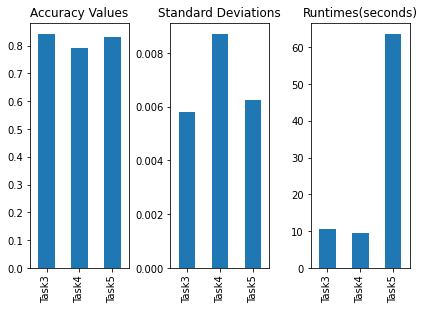

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3)
fig.tight_layout()
axes[0].title.set_text('Accuracy Values')
axes[1].title.set_text('Standard Deviations')
axes[2].title.set_text('Runtimes(seconds)')

tasks_list = ['Task3', 'Task4', 'Task5']
acc_data = pd.Series([0.8412, 0.79185, 0.83295], index=tasks_list)
acc_data.plot(kind = 'bar', ax=axes[0])

stddev_data = pd.Series([0.00580603134679791, 0.008697844560579362, 0.006262786919575036], index=tasks_list)
stddev_data.plot(kind = 'bar', ax=axes[1])

time_data = pd.Series([10.6, 9.6, 63.5], index=tasks_list)
time_data.plot(kind = 'bar', ax=axes[2])
plt.show()

## Tasks 3-5
As for tasks 3 to 5, the overall experimental results can be shown from the figure above. The accuracy of TAN is between the accuracies of Bayesian Network and NBC with the longest runtime.

### Task 3
The Bayesian Network Classifier has the best overall accuracy and the lowest standard deviation. This is because Bayesian Network Classifier uses the complete graph information and the CPT of all vertices. Because of this property, the time and memory complexity of this task is constructed of 2 parts:
1. The maximum size of the CPT table constructed by the markov blanket of the target variable. In the worst case, such size of CPT table is the size of CPT table for all vertices. And this is just the memory complexity of Task 2, which is O(V * (OutcomeSpaceMax ^ E)).
2. The size of the testing data, which can be represented by O(row * column), and row and column are the total rows and columns of test data.

And total time complexity for the cross validation of Bayesian Network Classifier is O(K(V * (OutcomeSpaceMax ^ E) + row)), where K is the number of the folds. And the memory complexity is O(K(V * (OutcomeSpaceMax ^ E) + row * column)) since the function must use all of the test data.

### Task 4
The Naive Bayes Classifier has the worst performance with lowest accuracy and highest standard deviation value, since it ignores the relationship between different vertices. The time complexity of this task is O(K(row * OutcomeSpaceMax * V)) which is to construct and search through the probability result for target variable. And the memory complexity is O(K(row * OutcomeSpaceMax * V + row * column)).

### Task 5
The Tree-augmented Naïve Bayes Classifier (TAN) tends to find the strong connections between vertices but may ignore some of the vertices relationships in most cases. This could explain why it performs slightly worse than the Bayesian Network Classifier. The time complexity is O(K(V^2 * OutcomeSpaceMax^3 + row)) so that it can find the strong inner relationships first then use it to construct the spanning tree, then do the classification. And the space complexity is O(K(V^2 * OutcomeSpaceMax^3 + row * column))
